In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from dpks import QuantMatrix

sns.set_theme(font="Arial", style="white", context="poster")

In [2]:

def preprocess_design_matrix(design_matrix):

    design_matrix = design_matrix[
        ((design_matrix['Sepsis Prob'] < 0.8) & 
        (design_matrix['Sepsis Prob'] > 0.50))
    ].copy()

    design_matrix['group'] = np.where(
        design_matrix['sepsis_or_septic_shock'] == 1, 2, 1
    )

    design_matrix['sample'] = design_matrix['injection']

    return design_matrix

In [3]:
def preprocess_data(raw_data, design_matrix):

    quant_matrix = QuantMatrix(
        quantification_file=raw_data[['Protein'] + [sample for sample in design_matrix['sample'].values]].copy(),
        design_matrix_file=design_matrix,
        annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
    )

    quant_data = quant_matrix.to_df()
    
    quant_data = quant_data[~((quant_data["ProteinLabel"].str.startswith("HV")) | (quant_data["ProteinLabel"].str.startswith("LV")) | quant_data["ProteinLabel"].str.startswith("KV"))]
    quant_data = quant_data[~quant_data["ProteinLabel"].str.startswith("IG")]
    quant_data = quant_data[~((quant_data["ProteinLabel"] == "HBA_HUMAN") | (quant_data["ProteinLabel"] == "HBB_HUMAN") | (quant_data["ProteinLabel"] == "HBD_HUMAN") | (quant_data["ProteinLabel"] == "HEMO_HUMAN"))]


    quant_matrix = QuantMatrix(
        quantification_file=quant_data,
        design_matrix_file=design_matrix,
        annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
    )

    return quant_matrix.annotate()     


In [4]:
def preprocess_test_data(raw_data, design_matrix):

    quant_matrix = QuantMatrix(
        quantification_file=raw_data[['Protein'] + [sample for sample in design_matrix['sample'].values]].copy(),
        design_matrix_file=design_matrix,
        annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
    )

    quant_data = quant_matrix.to_df()
    
    quant_data = quant_data[~((quant_data["ProteinLabel"].str.startswith("HV")) | (quant_data["ProteinLabel"].str.startswith("LV")) | quant_data["ProteinLabel"].str.startswith("KV"))]
    quant_data = quant_data[~quant_data["ProteinLabel"].str.startswith("IG")]
    quant_data = quant_data[~((quant_data["ProteinLabel"] == "HBA_HUMAN") | (quant_data["ProteinLabel"] == "HBB_HUMAN") | (quant_data["ProteinLabel"] == "HBD_HUMAN") | (quant_data["ProteinLabel"] == "HEMO_HUMAN"))]

    quant_matrix = QuantMatrix(
        quantification_file=quant_data,
        design_matrix_file=design_matrix,
        annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
    )

    return quant_matrix.annotate()   

# Model Training

In [5]:
ms_data = pd.read_csv(
    "../0_data/proteins_test_filtered.tsv"
    , sep="\t"
)

In [6]:
design_matrix_otrain = pd.read_csv(
    "../1_clinical_digital_family/design_matrix_test_sepsis_risk.tsv",
    sep='\t'
)

In [7]:
design_matrix_otrain['Sepsis Prob'].value_counts()

Sepsis Prob
1.000    15
0.908     9
0.999     7
0.544     5
0.907     5
         ..
0.792     1
0.279     1
0.872     1
0.885     1
0.727     1
Name: count, Length: 543, dtype: int64

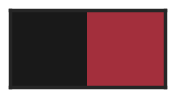

In [8]:
custom_palette = ["k", "#A32F3C"]  # Define hex colors
palette = sns.color_palette(custom_palette, as_cmap=True)
sns.palplot(custom_palette)

In [9]:
design_matrix_train = preprocess_design_matrix(design_matrix_otrain.copy())

<Axes: xlabel='Sepsis Prob', ylabel='Count'>

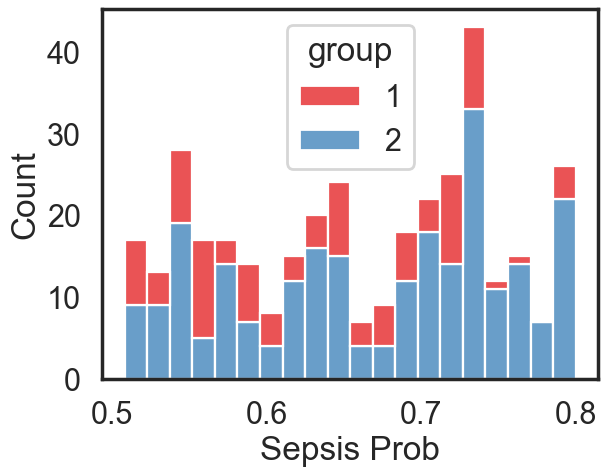

In [10]:
sns.histplot(
    design_matrix_train,
    x="Sepsis Prob",
    hue="group",
    palette="Set1",
    multiple="stack",
    bins=20
)

In [11]:
design_matrix_train['group'].value_counts()

group
2    249
1    108
Name: count, dtype: int64

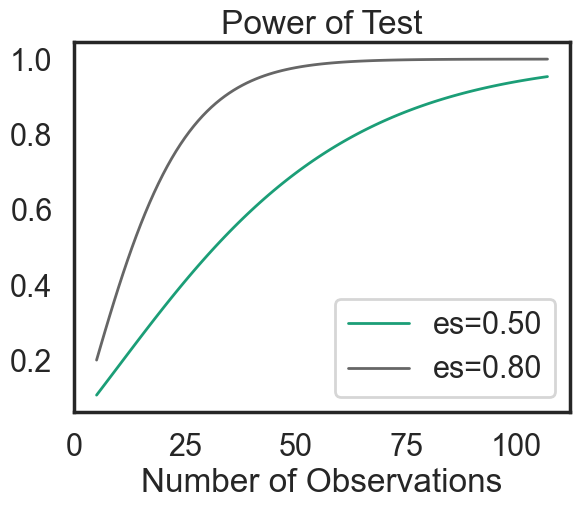

In [12]:
from statsmodels.stats.power import TTestIndPower
import matplotlib.pyplot as plt

# parameters for power analysis
effect_sizes = np.array([0.5, 0.8])
sample_sizes = np.array(range(5, design_matrix_train['group'].value_counts()[1]))


analysis = TTestIndPower()

analysis.plot_power(dep_var='nobs', nobs=sample_sizes, effect_size=effect_sizes)
plt.show()

In [13]:
quant_matrix_train = preprocess_data(ms_data, design_matrix=design_matrix_train)

In [14]:
quant_matrix_train = quant_matrix_train.compare(
    method="linregress",
    comparisons=(2,1),
    min_samples_per_group=2,
    level="protein",
    multiple_testing_correction_method="fdr_tsbh"
)

In [15]:
#quant_matrix_train.write("highrisk_sepsis_de_proteins.tsv")

In [16]:
quant_matrix_de = quant_matrix_train.to_df()

In [17]:
quant_matrix_de['Color'] = np.where(
    quant_matrix_de['CorrectedPValue2-1'] <= 0.01, 1, 0
)

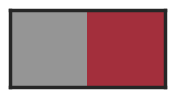

In [18]:
custom_palette = ["#959595", "#A32F3C"]  # Define hex colors
palette = sns.color_palette(custom_palette, as_cmap=True)
sns.palplot(custom_palette)

In [19]:
quant_matrix_de[quant_matrix_de['CorrectedPValue2-1'] <= 0.05]

,Protein,ProteinLabel,Gene,DEScore2-1,Group2Mean,Group1Mean,Group2Stdev,Group1Stdev,Log2FoldChange2-1,PValue2-1,...,SA_BOX_14-2490_S2-D10_1_6670,SA_BOX_14-1995_S2-E6_1_6638,SA_BOX_10-363_S2-G9_1_6273,SA_BOX_12-851_S5-G2_1_6412,SA_BOX_6-1989_S2-H3_1_5832,SA_BOX_3-882_S4-B1_1_5516,SA_BOX_6-92_S2-H10_1_5889,SA_BOX_7-2061_S4-H5_1_5946,SA_BOX_6-774_S2-D10_1_5885,Color
0,P02671,FIBA_HUMAN,FGA,0.842652,19.380127,19.271483,0.221966,0.225808,0.108644,0.000032,...,19.368848,19.251013,19.495020,18.951874,19.159876,18.960698,19.193966,19.383145,19.516108,1
5,P04275,VWF_HUMAN,VWF,0.864354,14.406460,14.080595,0.730151,0.583267,0.325864,0.000053,...,14.511854,13.566709,14.277612,14.426360,13.643604,14.812310,14.811867,13.964170,14.720750,1
11,P00748,FA12_HUMAN,F12,0.509294,13.371121,13.544136,0.509977,0.462810,-0.173016,0.002729,...,13.658238,13.271723,13.077377,13.351957,13.535197,14.202015,14.229691,14.029285,13.469875,0
16,P03952,KLKB1_HUMAN,KLKB1,0.486154,13.962893,14.100240,0.414813,0.363050,-0.137347,0.003152,...,14.170777,14.029708,13.846815,13.511082,14.316531,14.586638,15.388378,13.774424,13.836766,0
19,P19823,ITIH2_HUMAN,ITIH2,0.550980,16.935561,17.100112,0.468745,0.386896,-0.164551,0.001517,...,17.376068,17.208493,16.769952,16.897133,17.540665,17.819607,17.359677,17.392046,16.524415,0
35,P09871,C1S_HUMAN,C1S,0.453625,15.049739,15.161451,0.355522,0.289616,-0.111712,0.004358,...,15.412960,15.101755,15.348400,14.717473,14.735270,15.171188,15.420023,15.297284,15.699479,0
38,P02763,A1AG1_HUMAN,ORM1,0.509840,17.488879,17.358263,0.372964,0.354699,0.130616,0.002262,...,18.047657,17.357817,17.713257,16.402018,16.979717,17.109795,17.496272,17.353835,17.764320,0
39,P02750,A2GL_HUMAN,LRG1,0.899576,16.436186,16.155822,0.577681,0.550812,0.280364,0.000026,...,16.274941,16.031001,17.064379,15.309609,15.493083,15.572690,15.984142,16.830586,17.737636,1
40,Q04756,HGFA_HUMAN,HGFAC,0.640196,11.860918,12.078437,0.532039,0.569256,-0.217519,0.000599,...,11.103034,12.211987,12.156942,11.582185,12.416505,12.563684,12.007377,12.394465,11.478262,0
51,P04196,HRG_HUMAN,HRG,0.549298,15.544319,15.736064,0.560964,0.436990,-0.191745,0.001761,...,15.314972,15.485234,15.507834,15.415926,16.268782,16.172097,15.865633,16.290361,15.515466,0


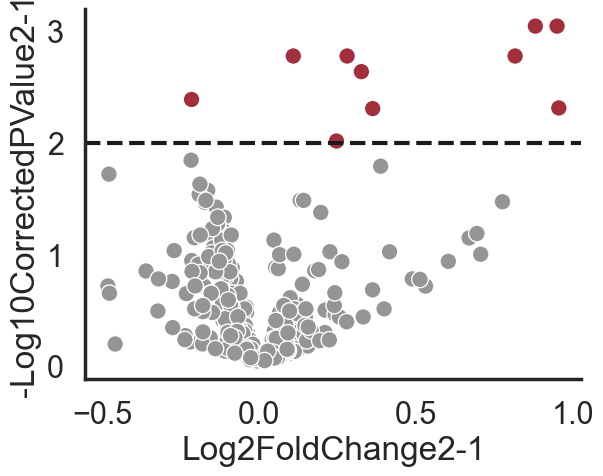

In [20]:
ax = sns.scatterplot(
    data=quant_matrix_de,
    x="Log2FoldChange2-1",
    y="-Log10CorrectedPValue2-1",
    hue="Color",
    #s=30,
    #alpha=0.8,
    legend=False,
    palette=palette
)

ax.axhline(
    -np.log10(0.01), c="k", linestyle="--"
)
sns.despine()
#ax.figure.set_size_inches((3, 3))

In [21]:
ax.figure.savefig(
    "sepsis_volcano_sepsis_to_non_sepsis_in_middle_group.pdf", dpi=300, bbox_inches="tight"
)